# LSTM Model for predicting trend

In [39]:
#imports
import numpy as np
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dropout
import sklearn
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.optimizers import Adam
from keras.layers import Dense
import keras.utils
from keras.layers import LSTM
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
import seed
import os
tf.get_logger().setLevel('ERROR')

In [40]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [41]:
#function to calculate rsi
def rsi(ohlc, period: int = 14) -> pd.Series:
    """See source https://github.com/peerchemist/finta
    and fix https://www.tradingview.com/wiki/Talk:Relative_Strength_Index_(RSI)
    Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements.
    RSI oscillates between zero and 100. Traditionally, and according to Wilder, RSI is considered overbought when above 70 and oversold when below 30.
    Signals can also be generated by looking for divergences, failure swings and centerline crossovers.
    RSI can also be used to identify the general trend."""

    delta = ohlc["Close"].diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    _gain = up.ewm(com=(period - 1), min_periods=period).mean()
    _loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = _gain / _loss
    return 100 - (100 / (1 + RS))

In [42]:
#lag granularity - days or hours
lag_granularity = "days"
#lag value
lag = 3
# type of analyser - TextBlob or vader
analyser = "vader"
# analyser = "TextBlob"
#dataset grouped type - day or hour
dataset_grouped_by = "day"

In [43]:
#read dataset
folder = "./../datasets/tweets_prices_volumes_sentiment/"+analyser+"/"+dataset_grouped_by+"_datasets/"
filename = folder+"/final_data_lag_"+lag_granularity+"_"+str(lag)+".csv" if (lag > 0) else folder+"/final_data_no_lag.csv"
df = pd.read_csv(filename)

In [44]:
#group by datetime
df = df.groupby('DateTime').agg(lambda x: x.mean())

In [45]:
#get change label
df["Change"] = (df["Close"] > df["Close"].shift(1)).astype(int)

add_RSI = False
add_longMAvg = False
add_shortMAvg = False

if(add_RSI):
    #calcualte RSI
    RSI = 14
    df['RSI'] = rsi(df, RSI)
    df = df.iloc[RSI:]

#calculate moving averages
if(add_shortMAvg):
    short_window = 9
    df['short_mavg'] = df.rolling(window=short_window)["Close"].mean()
    
if(add_longMAvg):
    long_window = 21
    df["long_mavg"] = df.rolling(window=long_window)["Close"].mean()
    
if(add_longMAvg):
    df = df.iloc[long_window:]
elif(add_RSI):
    df = df.iloc[RSI:]
elif(add_shortMAvg):
    df = df.iloc[short_window:]

In [46]:
#keep only wanted columns
features = ['Change', 'subjectivity', 'polarity','Tweet_vol','Volume_(BTC)'] if analyser == "Textblob" else ['Change', 'Close', 'pos_pol', 'neg_pol', 'Tweet_vol']

if(add_RSI):
    features.append("RSI")
    
if(add_longMAvg):
    features.append("long_mavg")
    
if(add_shortMAvg):
    features.append("short_mavg")

df = df[features]

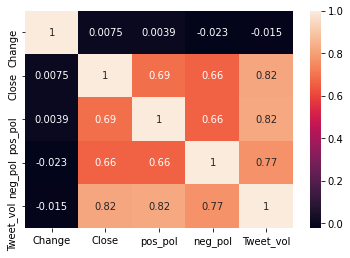

In [47]:
#plot correlation matrix
sn.heatmap(df.corr(), annot=True)
plt.show()

In [48]:
#creating copy so that data is not loaded once again
df_copy = df.copy()

In [49]:
print(features)

['Change', 'Close', 'pos_pol', 'neg_pol', 'Tweet_vol']


In [50]:
#number of previous records to consider for every example
n_lag = 3
#number of features
n_features = len(features)
#calculate total_features
total_features = n_lag*n_features

if(total_features == 0):
    total_features = n_features

In [51]:
#divide df into train and test
train_ratio = 0.85
data_len = len(df_copy)
train_size = int(data_len*train_ratio)

train = df_copy.iloc[:train_size]
test = df_copy.iloc[train_size:]

In [52]:
#prepare labels
train_y = train["Change"][n_lag:].values
test_y = test["Change"][n_lag:].values

train_y = train_y.reshape(len(train_y), 1)
test_y = test_y.reshape(len(test_y), 1)

In [53]:
#normalise features
xscaler = MinMaxScaler(feature_range=(0, 1))
train = xscaler.fit_transform(train)
test = xscaler.transform(test)

In [54]:
#add lagged data to records
train_reframed = series_to_supervised(train, n_lag, 1)
train_reframed =  train_reframed.reset_index()
train_reframed = train_reframed.drop(['index'], axis=1)

test_reframed = series_to_supervised(test, n_lag, 1)
test_reframed =  test_reframed.reset_index()
test_reframed = test_reframed.drop(['index'], axis=1)

In [55]:
def get_cols_to_rem_label(n_lag, n_features, label_col):
    to_rem = []
    for i in range(1, n_features+1):
        for j in range(0, n_lag+1):
            if(j!=0 or i != label_col):
                if(j == 0):
                    to_rem.append("var"+str(i)+"(t)")
                else:
                    to_rem.append("var"+str(i)+"(t-"+str(j)+")")
    return to_rem
    
def get_cols_to_rem_feat(n_lag, n_features, label_col):
    #uncomment the below line to only remove the last price
    to_rem = ["var1(t)", "var2(t)"]
    return to_rem

In [56]:
train_reframed = train_reframed.drop(get_cols_to_rem_feat(n_lag, n_features, 1), axis=1)
test_reframed = test_reframed.drop(get_cols_to_rem_feat(n_lag, n_features, 1), axis=1)

In [57]:
#tprepare data
train = train_reframed.values
test = test_reframed.values
train_labels = train_y
test_labels = test_y

In [58]:
#remove the last set of values(data of time to be predicted)
train = train[:, :total_features]
test = test[:, :total_features]

In [59]:
#keep only prices array
train_X, train_y = train[:, :total_features], train_y[:, -1]
test_X, test_y = test[:, :total_features], test_y[:, -1]

In [60]:
# reshape input to be 3D [samples, timesteps, features]
if(n_lag > 0):
    train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
else:
    train_X = train_X.reshape((train_X.shape[0], 1, n_features-1))
    test_X = test_X.reshape((test_X.shape[0], 1, n_features-1))

In [61]:
#set labels for training data to categorical
train_y = keras.utils.to_categorical(train_y, 2)

In [62]:
np.random.seed(1)
tf.random.set_seed(1)

# design network
model = Sequential()
neurons = 128
epochs = 50
dropout = 0.25
batch_size = 5
activ_func = "linear"

model.add(LSTM(neurons, return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2]), activation=activ_func))
model.add(Dropout(dropout))

# model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
# model.add(Dropout(dropout))
# model.add(LSTM(neurons, return_sequences=False, activation=activ_func))
# model.add(Dropout(dropout))

model.add(Dense(2, activation="softmax"))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False,validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 68,866
Trainable params: 68,866
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
61/61 - 0s - loss: 0.6880 - accuracy: 0.5311 - val_loss: 0.7221 - val_accuracy: 0.5065
Epoch 2/50
61/61 - 0s - loss: 0.6866 - accuracy: 0.5377 - val_loss: 0.7274 - val_accuracy: 0.5065
Epoch 3/50
61/61 - 0s - loss: 0.6822 - accuracy: 0.5377 - val_loss: 0.7326 - val_accuracy: 0.5065
Epoch 4/50
61/61 - 0s - loss: 0.6802 - accuracy: 0.5344 - val_loss: 0.7351 - val_accur

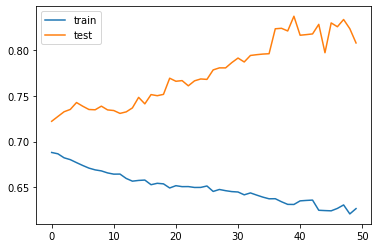

In [63]:
#plot loss graph

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

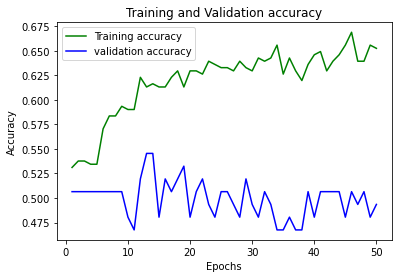

In [64]:
#plot training and validation accuracy

loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,epochs + 1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [65]:
#predict values for test data
if(n_lag > 0):
    test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
else:
    test_X = test_X.reshape((test_X.shape[0], 1, n_features-1))

pred = model.predict(test_X)

if(n_lag > 0):
    test_X = test_X.reshape((test_X.shape[0], n_lag* n_features,))
else:
    test_X = test_X.reshape((test_X.shape[0], n_features-1,))

In [66]:
#change back from categorical
pred = np.argmax(pred, axis=1)

In [67]:
# calculate RMSE
mse = (mean_squared_error(test_y, pred))
print('Test MSE: %.3f' % mse)
rmse = sqrt(mean_squared_error(test_y, pred))
print('Test RMSE: %.3f' % rmse)

Test MSE: 0.508
Test RMSE: 0.713


In [68]:
#calculate accuracy
prices = pd.DataFrame()
prices["Actual"] = test_y
prices["Predicted"] = pred

prices["Correct"] = (prices["Actual"] - prices["Predicted"]) == 0
incorrect = prices.loc[prices['Correct'] == False]
incorrect_len = len(incorrect)
prices_len = len(prices)

print("Accuracy = ",((prices_len-incorrect_len)/prices_len))

Accuracy =  0.49230769230769234


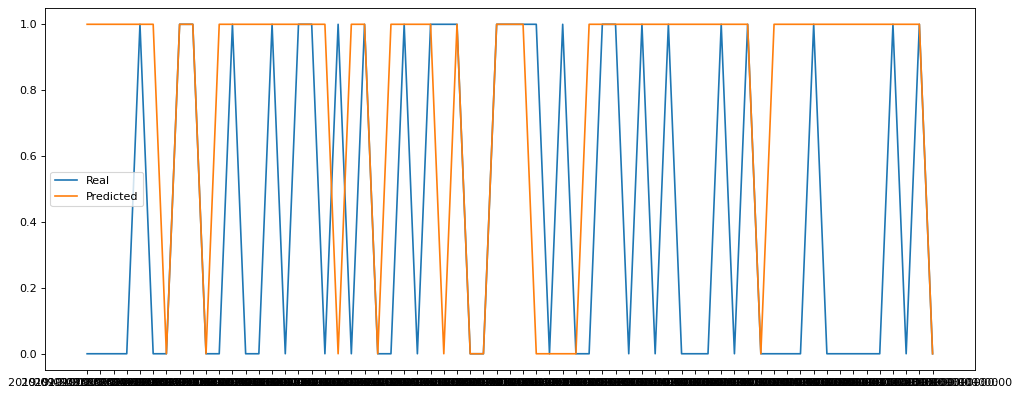

In [69]:
#plot price trends
times = pd.Series(df.index)
times = times[n_lag:]
times = times[train_size:]
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(times[:100], test_y[:100], label='Real')
plt.plot(times[:100], pred[:100], label='Predicted')
plt.legend()
plt.show()